# Лабораторная работа №1
Выполнил студент группы 9382 Павлов Роман, вариант 10

### Цель работы:
Изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

### Задачи:
1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио-сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования.
5. Эффект "Эхо". Получить сигнал после работы аудио-эффекта.
6. <b>Бонусное задание:</b> эффект "Distortion" (классический вариант). Получить сигнал после работы аудио-эффекта.

## Подготовка к выполнению работы
При выполнении работы используются библиотеки <b>numpy</b>, <b>scipy</b> для обработки сигнала, а также <b>matplotlib</b> и <b>IPython</b> для отображения результатов обработки.

Определена функция <b>plot_output</b> для упрощения работы с графиком в рамках лабораторной работы.

In [1]:
import scipy.signal as sig
import scipy.io.wavfile as writer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio as audio

def plot_output(axis):
    plt.figure(figsize=(15, 7))
    plt.axes().set_facecolor((0.95, 0.95, 0.95))
    plt.xlabel("Время, с")
    plt.ylabel("Амплитуда, мБ")
    for i in axis:
        plt.plot(i[0], i[1], color=i[2], linewidth = i[3])
    plt.show()

## Построение огибающей сигнала
Для построения огибающей массив данных разбивается на отрезки, содержащие по <b>n</b> точек. Для каждого такого отрезка вычисляется среднее значение сигнала по модулю, по средним значениям строится график огибающей.

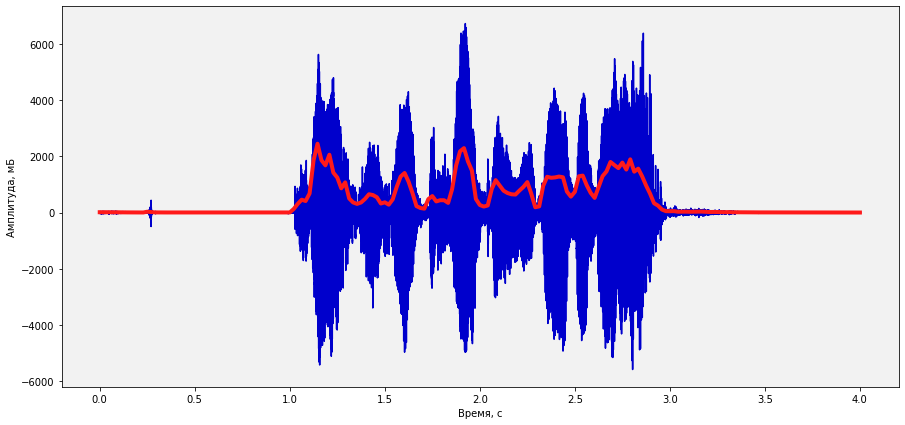

In [2]:
n = 1000 # количество отсчётов в отрезке

sample_rate, data = writer.read("03-01-05-01-01-02-10_A10.wav")
length = len(data)

time = np.arange(length)/sample_rate
curve_time = time[::n]

curve_img = [0 for i in range(len(curve_time))]
for i in range(len(curve_img)):
    aver = 0
    for j in range(n):
        if i*n + j >= length:
            break
        aver = aver + abs(data[i*n + j])
    aver /= n
    curve_img[i] = aver

plot_output(( (time, data, (0.0, 0.0, 0.8), None),
             (curve_time, curve_img, (1.0, 0.1, 0.1), 4) ))
audio("03-01-05-01-01-02-10_A10.wav", rate=sample_rate)

При длине отрезка, равной 1000 отсчётов, огибающая (красная кривая) выглядит, как на графике выше.

## Фильтрация сигнала
Указаны две критические частоты для выбранного типа фильтрации (фильтр средних частот), использованы функции библиотеки <b>scipy</b> для фильтрации звука.

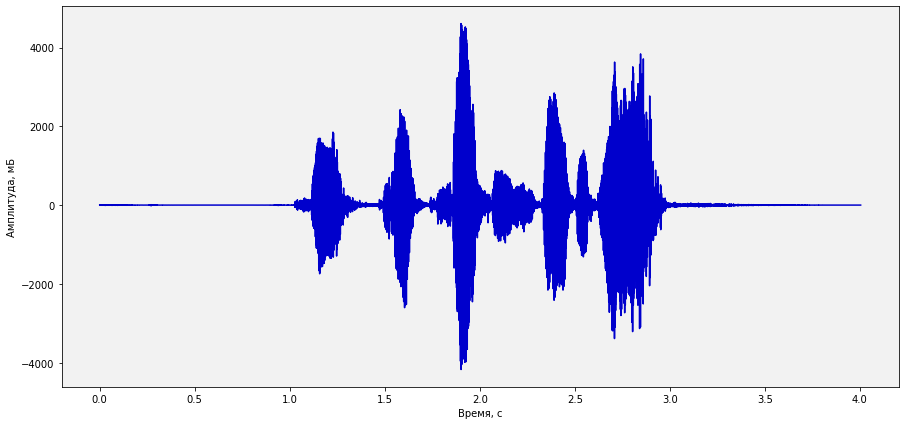

In [3]:
critical_freq_1 = 500
critical_freq_2 = 1200

a, b = sig.butter(1, [2*critical_freq_1/sample_rate, 2*critical_freq_2/sample_rate], "bandpass")
filtered = sig.filtfilt(a, b, data)
writer.write("filtered.wav", sample_rate, filtered.astype("int16"))

plot_output(( (time, filtered, (0.0, 0.0, 0.8), None), ))
audio("filtered.wav", rate=sample_rate)

Как можно услышать из модифицированного сигнала, низкие и высокие частоты приглушены, что соответствует принципу действия фильтра средних частот. Теперь аудио напоминает разговор по телефону. Также на графике видно, что некоторые участки кривой, присутствовавшие ранее на нём, теперь отсутствуют, что свидетельствует о подавлении крайних частот.

## Детектор сигнал/шум
Было определено среднее сигнала по амплитуде:
$\large mid = \frac{1}{N}\sum\limits_{k = 0}^{N-1} |x(k)|$,\
а также указан коэффициент $\alpha : 0\le \alpha \le 1$ и количество отсчётов $k$, которое должен продлиться сигнал/шум для изменения статуса на шум/сигнал соответственно.\

Если $|x(i)|$ в течение $k$ отсчётов больше $a*mid$, то выходной сигнал $y(i) = x(i)$.\
Если $|x(i)|$ в течение $k$ отсчётов не превышает $a*mid$, то $y(i) = 0$, то есть удаляется так называемый шум.\

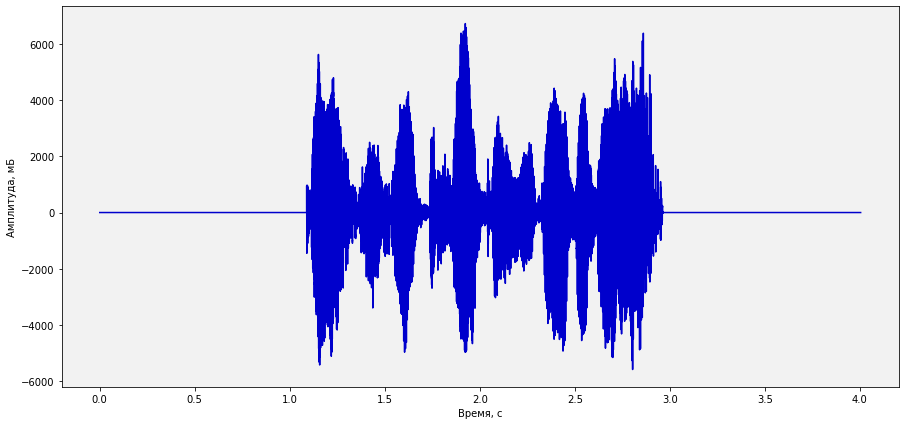

In [4]:
a = 0.2
mn = np.mean(np.abs(data))
k = sample_rate//1000

def noise_reduction(processed, coef, mean, steps):
    signals_data = []
    signal = False
    count_sig = 0
    count_noise = 0
    for i in processed:
        if abs(i) > coef*mean:
            count_sig += 1
            count_noise = 0
        else:
            count_noise += 1
            count_sig = 0
        if count_sig >= steps and not signal:
            signal = True
        if count_noise >= steps and signal:
            signal = False
        if signal:
            signals_data.append(i)
        else:
            signals_data.append(0)
    return signals_data
    
signals_data = noise_reduction(data, a, mn, k)

first_sig = next((i for i, x in enumerate(signals_data) if x != 0), None)
last_sig = len(signals_data) - next((i for i, x in enumerate(reversed(signals_data)) if x != 0), None)

writer.write("noise_reduced.wav", sample_rate, np.array(signals_data).astype("int16"))

plot_output(((time, signals_data, (0.0, 0.0, 0.8), None),))
audio("noise_reduced.wav", rate = sample_rate)

Из графика видно, что звук с низкой амплитудой был удалён, что также отразилось и на восприятии аудиофайла - более не слышны посторонние шумы, такие как вздохи, остался "чистый" голос.

## Эффект "Эхо"

Для воспроизведения данного эффекта задаются линии задержки (8 линий в данной работе), каждая линия характеризуется числом $D_i$ - задержкой сигнала в отсчётах и коэффициентом $\alpha_i$ - так называемым весовым коэффициентом, определяющим силу сигнала на соответствующей линии.

Для каждой линии задержки осуществляется сдвиг сигнала на соответствующее число отсчётов и умножение его на весовой коэффициент, после чего линии задержки накладываются друг на друга, фильтруются ФНЧ, умножаются на коэффициент $\gamma$ соотношения чистого/обработанного сигнала, а затем накладываются уже на исходный сигнал. В результате применения множественной задержки получаемый эффект имитирует отражение звуковых волн - реверберацию.

Эффект реверберации далее применяется к сигналу с подавленным шумом для лучшего качества результата.

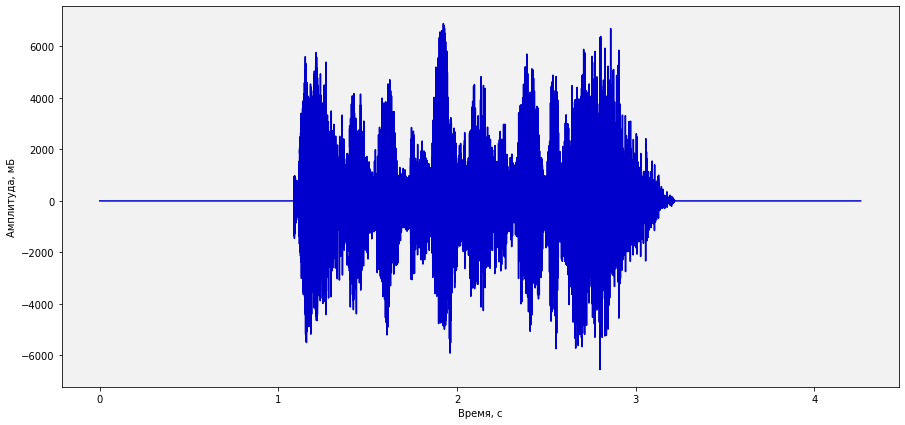

In [5]:
gamma = 0.5
filter_coef = 1/16
delay_coefs = [0.8, 0.63, 0.49, 0.43, 0.39, 0.35, 0.32, 0.3]
delay_lines = [int(2/33*sample_rate)] + 7*[0]
for i in range(1, 8):
    delay_lines[i] = int(delay_lines[i-1] * 2**(-i/8))


def reverberation(processed, out_coef, weights, lines):
    reverbable = processed[:]
    reverbed = list(map(lambda x: delay_coefs[0] * x, reverbable))
    last_delay = 0
    for i in range(1, len(delay_lines)):
        last_delay += delay_lines[i]
        reverbed += delay_lines[i] * [0]
        for j in range(last_delay, len(reverbable)):
            reverbed[j] += delay_coefs[i] * reverbable[j - last_delay]
            
    a, b = sig.butter(1, filter_coef, "lowpass")
    reverbed = sig.filtfilt(a, b, np.array(reverbed))
    reverbed = list(map(lambda x: x*gamma, reverbed))
    
    reverbable += sum(delay_lines)*[0]
    for i in range(delay_lines[0], len(reverbable)):
        reverbable[i] += reverbed[i - delay_lines[0]]
    return reverbable

with_reverb = reverberation(signals_data, gamma, delay_coefs, delay_lines)
writer.write("reverberation.wav", sample_rate, np.array(with_reverb).astype("int16"))

rev_time = np.arange(len(with_reverb))/sample_rate
plot_output(( (rev_time, with_reverb, (0.0, 0.0, 0.8), None), ))
audio("reverberation.wav", rate = sample_rate)

В результате применения эффекта реверберации к сигналу создано ощущение "объёмности звука", фраза из аудио теперь звучит так, будто произносится в просторном зале. Также при анализе графика можно заметить, что участков сигнала с низкой амплитудой стало меньше вследствие неоднократного наложения сигнала.

## Эффект "Distortion"
Суть данного эффекта заключается в том, чтобы оставлять сигнал, меньший заданного порога или равный ему по значению, прежним, и усиливать сигнал до определённого максимума (с сохранением знака) при условии, что он по значению превышает этот порог. Полученный эффект называют "Distortion" или "Искажение".

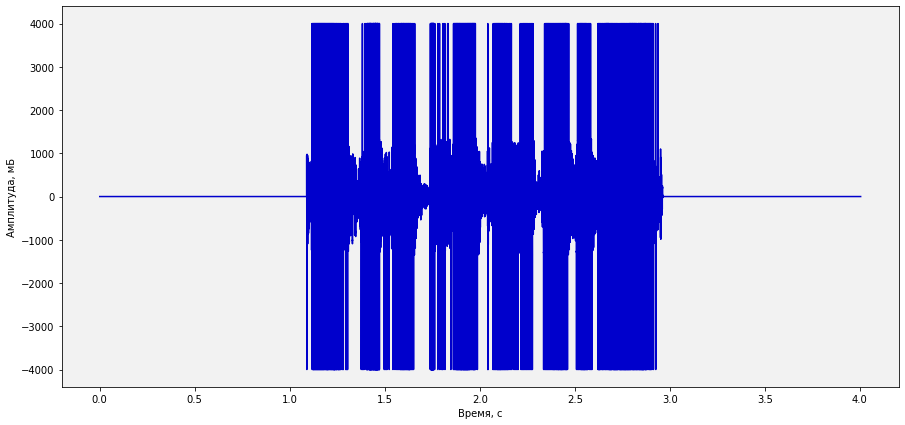

In [6]:
Max = 4000
threshold = mn * 3

def distortion(processed, mx, th):
    distorted = []
    for i in processed:
        if abs(i) <= th:
            distorted.append(i)
        else:
            distorted.append(Max*np.sign(i))
    return distorted

distorted = distortion(signals_data, Max, threshold)
writer.write("distortion.wav", sample_rate, np.array(distorted).astype("int16"))
plot_output(( (time, distorted, (0.0, 0.0, 0.8), None), ))
audio("distortion.wav", rate = sample_rate)

## Вывод
В ходе выполнения лабораторной работы были частично изучены возможности библиотек Python для обработки звукового сигнала, также были применены на практике знания о звуковых волнах. Приобретён навык обработки звуковых файлов расширения <b>.wav</b>.